In [28]:
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END, START

In [3]:
load_dotenv()
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


In [20]:
class SentimentSchema(BaseModel):
    sentiment: Literal["Postitive","Negative"] =  Field(description="Sentiment of the review")

In [21]:
llm_structured = llm.with_structured_output(SentimentSchema)

In [24]:
prompt = 'What is the sentiment of the following review - The software too good'
llm_structured.invoke(prompt).sentiment

'Postitive'

In [26]:
class ReviewState(TypedDict):

    review: str
    sentiment: Literal["Positive","Negative"]
    diagnosis: dict
    response: str


In [27]:
def find_setiment(state:ReviewState):

    prompt = f'What is the sentiment of the following review: \n {state["review"]}'
    sentiment = llm_structured.invoke(prompt).sentiment
    return {"sentiment":sentiment}


In [30]:
graph = StateGraph(ReviewState)

graph.add_node("find_setiment",find_setiment)

graph.add_edge(START,"find_setiment")
graph.add_edge("find_setiment",END)

workflow = graph.compile()

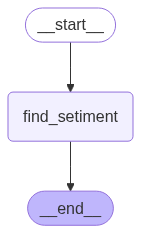

In [31]:
workflow

In [32]:
initia_state = {"review":"software is toooo gooood"}
final_state = workflow.invoke(initia_state)
final_state

{'review': 'software is toooo gooood', 'sentiment': 'Postitive'}